In [1]:
import cv2 
import matplotlib.pyplot as plt
import os
from sys import exit
from cv2 import *#xfeatures2d
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from skimage.measure import ransac
from skimage.transform import AffineTransform, warp
from scipy.ndimage import affine_transform
import glob
from mpl_toolkits import mplot3d
import open3d as o3d

In [10]:
# Copute SIFT matches
img1 = cv2.imread('lxtek1.jpg',0)  #queryimage # left image
img2 = cv2.imread('lxtek2.jpg',0) #trainimage # right image
sift = cv2.SIFT_create()
#sift = cv2.KAZE_create()
#sift = cv2.BRISK_create(70, 4)
#sift = cv2.ORB_create(nfeatures=2000)


# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 20)
search_params = dict(checks=100)


#if sift
#FLANN
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2) \
# extract points
good=[]
pts1 = []
pts2 = []
for i,(m,n) in enumerate(matches):
    if m.distance < 0.30*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
print(len(good), ' Matches') 

image_size = img1.shape

73  Matches


In [26]:
#Compute the Camera Matrix
#iphone x camera calibration - does checkerboard match the online values?
check_width = 8
check_height = 6
#winSize = 
objp = np.zeros((1, check_width * check_height, 3), np.float32)
objp[0,:,:2] = np.mgrid[0:check_width, 0:check_height].T.reshape(-1, 2)
objpoints = []
imgpoints = []

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
patternSize = (check_width,check_height)
check_imgs = glob.glob('*V2.jpg')

for file in check_imgs:
    image = cv2.imread(file,0)
    ret, corners = cv2.findChessboardCorners(image, patternSize, None)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(image, corners, (11,11),(-1,-1), criteria)
        imgpoints.append(corners2)
        image = cv2.drawChessboardCorners(image, patternSize, corners2, ret)
        #plt.imshow(image)
        #plt.show()
# Get camera matrix        
file = check_imgs[0] 
image = cv2.imread(file,0)        
h,w = image.shape[:2]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape, None, None)
K = mtx

pts1 = np.asarray(pts1,dtype=np.float32)
pts2 = np.asarray(pts2,dtype=np.float32)

E,_ = cv2.findEssentialMat(pts1,pts2,cameraMatrix=K,method=2)

R,_ = cv2.Rodrigues(rvecs[2])
t=tvecs[2]
print(K)
print(E)
print(R)
print(t)
print(F)

[[4.10341172e+03 0.00000000e+00 5.07419433e+02]
 [0.00000000e+00 4.10780286e+03 6.54188274e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-0.16595847 -0.04628412 -0.65093534]
 [ 0.16357647  0.33353133 -0.24731219]
 [ 0.32141763  0.49393356  0.01246457]]
[[ 0.99850045 -0.00101037 -0.0547341 ]
 [-0.00237305  0.99809097 -0.0617154 ]
 [ 0.05469196  0.06175274  0.99659189]]
[[-3.54407599]
 [-2.24951113]
 [45.05638392]]
[[-1.12281079e-08 -7.45647976e-09 -1.35803878e-04]
 [ 4.99232974e-09  2.03444773e-08 -1.00331559e-04]
 [ 6.28406331e-05  1.19473041e-04  2.63680634e-02]]


In [5]:
#Compute Essential Matrix
E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.FM_RANSAC, prob=0.99,
                               threshold=0.4, mask=None)
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]
print(E)

[[-0.20254625 -0.13612497 -0.58885484]
 [ 0.06673411  0.3494785  -0.36030011]
 [ 0.23535416  0.53090735  0.00599671]]


In [8]:
#R,t = decompose_essential_matrix(E,KL,pts1,pts2)
points,R,t,mask = cv2.recoverPose(E,pts1,pts2,R = None,t = None,mask = None)
K_inv = np.linalg.inv(K)
F = K_inv.T @ E @ K_inv
print("R = {} \n t = {}".format(R,t))
print(F)

R = [[ 0.68953181  0.63421314 -0.34974214]
 [-0.33789081  0.70882244  0.61919346]
 [ 0.64060571 -0.30877893  0.70305042]] 
 t = [[-0.41874676]
 [ 0.71360206]
 [-0.56162555]]
[[-1.12281079e-08 -7.45647976e-09 -1.35803878e-04]
 [ 4.99232974e-09  2.03444773e-08 -1.00331559e-04]
 [ 6.28406331e-05  1.19473041e-04  2.63680634e-02]]


In [27]:
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)

In [28]:
R1,R2,P1,P2= cv2.stereoRectify(K,None,K,None,(image_size[1],image_size[0]),R,t,flags = cv2.CALIB_ZERO_DISPARITY)[:4]

In [32]:
#print(R1 @ R2.T) # these gives the rotation between the two camera
mapx1,mapy1 = cv2.initUndistortRectifyMap(K,None,R1,P1,(image_size[1],image_size[0]),cv2.CV_16SC2)
mapx2,mapy2 = cv2.initUndistortRectifyMap(K,None,R2,P2,(image_size[1],image_size[0]),cv2.CV_16SC2)
print("shape = ",mapx1.shape,mapy1.shape)

shape =  (1280, 960, 2) (1280, 960)


In [40]:
#rectified_imgL = cv2.remap(img1,mapx1,mapy1,interpolation=cv2.INTER_CUBIC,borderMode=cv2.BORDER_CONSTANT)
rectified_imgR = cv2.remap(img2,mapx2,mapy2,interpolation=cv2.INTER_CUBIC,borderMode=cv2.BORDER_CONSTANT)
print(np.sum(rectified_imgR))
#plt.imshow(rectified_imgR)
#plt.imshow(img1)
#plt.show()
#plt.close()

0


In [43]:
# Stereo rectification (uncalibrated variant)
# Adapted from: https://stackoverflow.com/a/62607343
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), F, imgSize=(w1, h1)
)
#print(H1)
#print(H2)
# Undistort (rectify) the images and save them
# Adapted from: https://stackoverflow.com/a/62607343
rectified_imgL = cv2.warpPerspective(img1, H1, (w1, h1))
rectified_imgR = cv2.warpPerspective(img2, H2, (w2, h2))

In [70]:
# Defining the Parameter for stereoSGBM
min_disparity =  20#-1
max_disparity = 200#159
num_disparity = max_disparity - min_disparity
SADWindowSize = 3
uniqueness = 15
speckle_windows_size = 10
speckle_range = 5
P1 = 8*3*SADWindowSize**2
P2 = 32*3*SADWindowSize**2

left_matcher = cv2.StereoSGBM_create(minDisparity=min_disparity,numDisparities=num_disparity,blockSize=SADWindowSize
                               ,P1= 8*3*SADWindowSize**2,P2=32*3*SADWindowSize**2,uniquenessRatio=uniqueness,disp12MaxDiff=2,
                                speckleWindowSize=speckle_windows_size,speckleRange=speckle_range)

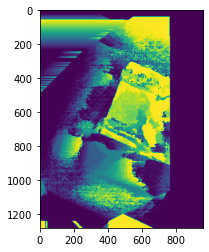

In [71]:
left_disparity = left_matcher.compute(rectified_imgL,rectified_imgR)
right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)
right_disparity = right_matcher.compute(rectified_imgR,rectified_imgL)
plt.imshow(right_disparity)

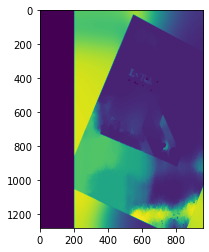

In [72]:
# wls filtering
sigma = 1.5
lambda_ = 8000
wls = cv2.ximgproc.createDisparityWLSFilter(left_matcher)
wls.setLambda(lambda_)
wls.setSigmaColor(sigma)
filtered_disparity = wls.filter(left_disparity,rectified_imgL,disparity_map_right = right_disparity)
cv2.filterSpeckles(filtered_disparity,0,400,max_disparity-5)
_,filtered_disparity = cv2.threshold(filtered_disparity,0,max_disparity*16,cv2.THRESH_TOZERO)
filtered_disparity = (filtered_disparity/16).astype(np.uint8)
plt.imshow(filtered_disparity)
plt.show()
plt.close()
#cv2.imshow('filter',filtered_disparity)
#cv2.imwrite("wls_disparity.png",filtered_disparity)

45.25150281177136


/home/e.conway/.conda/envs/MyEnv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


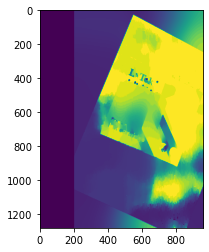

In [73]:
b = np.linalg.norm(t)
print(b)
depth_map = K[0,0]*b / (filtered_disparity)
depth_map = depth_map.astype('uint16')
plt.imshow(depth_map)

In [99]:
# Reprojection matrix
Q = np.float32([[1,0,0,-K[0,2]],
                [0,1,0,-K[1,2]],
                [0,0,0,K[0,0]],
                [0,0,-1/b,(K[0,2]-K[0,2])/b]])
print(Q)
Q[3,2] = -2.0

[[ 1.0000000e+00  0.0000000e+00  0.0000000e+00 -5.0741943e+02]
 [ 0.0000000e+00  1.0000000e+00  0.0000000e+00 -6.5418829e+02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  4.1034116e+03]
 [ 0.0000000e+00  0.0000000e+00 -2.2098714e-02  0.0000000e+00]]


In [100]:
points = cv2.reprojectImageTo3D(filtered_disparity,Q)
points = points.reshape(-1,3)
colors = rectified_imgL.reshape(-1,3)
colors = np.flip(colors,axis = 1)/255
xyzrbg = np.concatenate((points,colors),axis=1)

In [101]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyzrbg[:,:3])
pcd.colors = o3d.utility.Vector3dVector(xyzrbg[:,3:])
o3d.io.write_point_cloud('data_LxTek.ply',pcd)

True